<Axes: xlabel='X', ylabel='Y'>

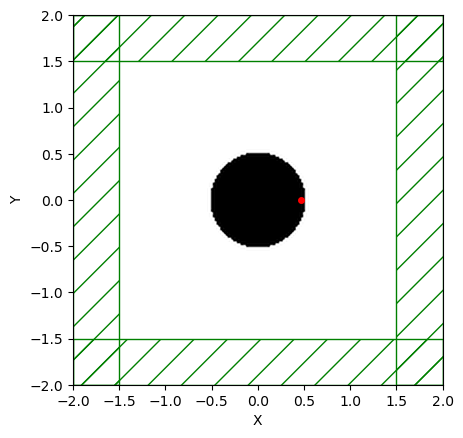

In [49]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
mp.verbosity(0)

'''Физические параметры'''
Si = 3.4
SiO2 = 1
wl = 1.1 # central wavelength (micron)
fcen = 1/wl #central frequency
df = 0.1 # pulse width (in frequency)
r = wl/(Si*2*np.pi)*10 # disk radius
pad = 1 # padding between waveguide and edge of PML
dpml = 0.5  # thickness of PML
sxy = int(2*(r + pad + dpml))  # cell size

wg_width = 0.5 # waveguide width (micron)
distance = 0.1 # расстояние между краями диска и волновода (микроны)
angle = np.radians(45) # угол между краями углубления и центром диска (градусы)
wg_center = mp.Vector3(0, (r+distance)*np.sqrt(np.cos(angle)) + wg_width/2, 0)
wg_size = mp.Vector3(sxy, wg_width, 0)

'''Параметры симуляции'''
time = 300
resolution = 50 #pixels per micron
src_center = mp.Vector3(0.9*r)

'''Optimization'''
minimum_length = 0.09
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e
design_region_resolution = int(resolution)
design_region_width = 2*r
design_region_height = wg_width + 2*distance
design_region_center = wg_center

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), mp.Medium(index=SiO2), mp.Medium(index=Si), grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=design_region_center,
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [#mp.Block(center=design_region.center, size=design_region.size, material=design_variables), # оптимизируемая зона
    #mp.Block(size=wg_size, center=wg_center, material=mp.Medium(index=Si)), # волновод
    mp.Cylinder(radius=r, center=(0, distance, 0), material=mp.Medium(index=SiO2)), # вырез в волноводе
    mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск
    
]

src = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df), 
                 mp.Ez, 
                 center = src_center,
                 size = mp.Vector3(0))
]
sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    geometry=geometry,
    sources=src,
    resolution=resolution,
    boundary_layers=[mp.PML(dpml)],
    default_material=mp.Medium(index=SiO2)
)

sim.plot2D()

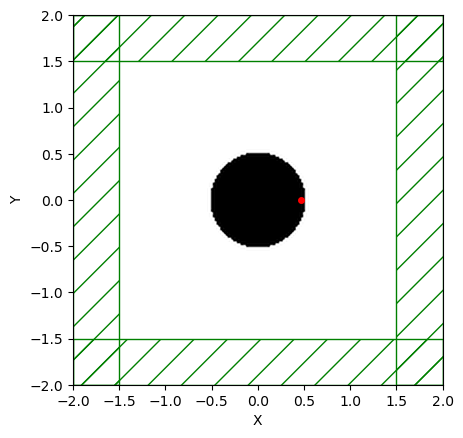

FloatProgress(value=0.0, description='0% done ', max=400.0)

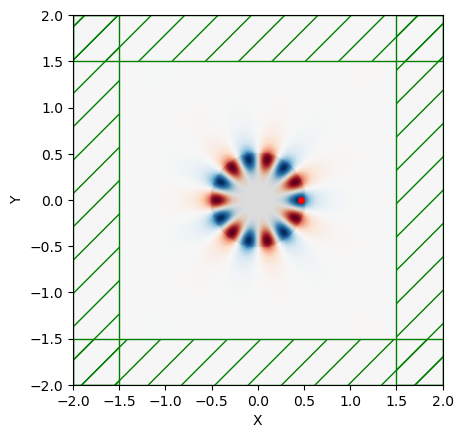

FloatProgress(value=400.0, description='0% done ', max=450.0, min=400.0)

In [50]:
sim.plot2D()
plt.show()
h = mp.Harminv(mp.Ez, src_center, fcen, df)
sim.run(mp.after_sources(h),
        until_after_sources=time)

sim.plot2D(fields=mp.Ez, field_parameters={'alpha':0.9, 'cmap':'RdBu'})
plt.savefig("microdisk.png")
plt.show()
#sim.reset_meep()
animate_sim = mp.Animate2D(fields=mp.Ez,
                       normalize = True,
                       field_parameters={'alpha':0.9, 'cmap':'RdBu'})

sim.run(mp.at_every(1,animate_sim), until=50)
plt.close()
animate_sim.to_gif(10, "microdisk.gif")
animate_sim.to_jshtml(10)


In [51]:
freqs = [m.freq for m in h.modes]
wls = [1/m.freq for m in h.modes]
Qs = [m.Q for m in h.modes]
dfreqs = [fcen/q for q in Qs]
#print(*h.modes, sep='\n')
print(f'frequencies: {freqs}')
print(f'wavelengths: {wls}')
print(f'Q: {Qs}')
print(f'frequency width: {dfreqs}')

frequencies: [0.8670222076471844, 0.8926038595953955]
wavelengths: [1.1533729945783904, 1.120317808678629]
Q: [74.87543507833037, 41845.49965578553]
frequency width: [0.012141377317405508, 2.1724938561349425e-05]


In [52]:
def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    
    # interpolate to actual materials
    return projected_field.flatten()


# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

circle_mask = (X_g**2 + Y_g**2 <= r)
wg_mask = (X_g == -design_region_width / 2) & (Y_g <= wg_width / 2)

# Define the core mask
'''left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation / 2) <= waveguide_width / 2
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation / 2) <= waveguide_width / 2
)'''
Si_mask = circle_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False




In [53]:


field = mpa.FourierFields(
    sim,
    mp.Volume(
        center=src_center,
        size=mp.Vector3(0),
    ),
    component=mp.Ez
)

def J(field):
    return npa.mean(field)

ob_list = [field]
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=df,
    nf=10,
    decay_by=1e-5,
)


<Axes: xlabel='X', ylabel='Y'>

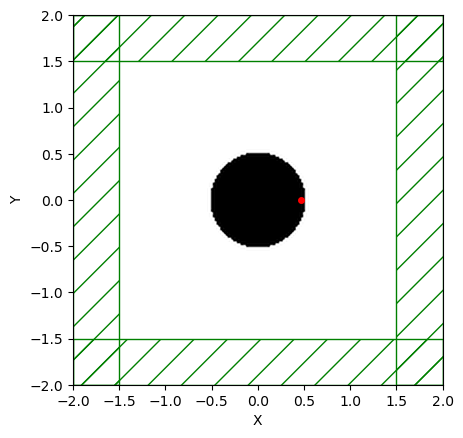

In [54]:
sim.plot2D()

Starting forward run...
[-0.34529019 -0.19075447j  0.41469552 +0.47032091j
 -0.44882027 -0.82796323j 30.81459987+18.85444082j
  0.38416196 +0.06266613j  0.37477586 +0.05080985j
 -0.59771874 -0.23603476j  0.45773817 +0.3572174j
 -0.23333752 -0.39323268j  0.03802967 +0.38650896j]
(3.085883432917698+1.8533978926739458j)


/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


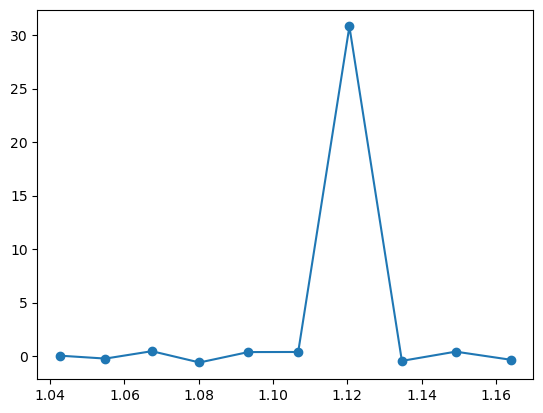

In [55]:
x = np.ones((Nx*Ny,)) * 0
f0, _ = opt([mapping(x, eta_i, 128)], need_gradient=False)
frequencies = opt.frequencies
[dftfld] = opt.get_objective_arguments()
plt.figure()
plt.plot(1 / frequencies, dftfld, "-o")
print(dftfld)
print(f0)


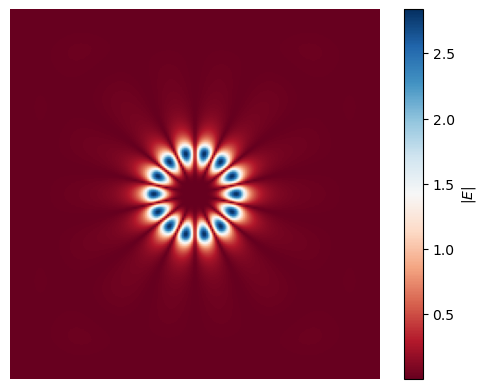

In [77]:
def plot_field_module(sim, size, center):
    dielectric = sim.get_array(
        component=mp.Dielectric,
        size=size,
        center=center
        )
    dielectric = np.transpose(dielectric)
    
    Ex = sim.get_array(
        component=mp.Ex,
        size=size,
        center=center
        )
    Ey = sim.get_array(
        component=mp.Ey,
        size=size,
        center=center
        )
    Ez = sim.get_array(
        component=mp.Ez,
        size=size,
        center=center
        )
    # plotting
    
    fig, ax = plt.subplots()
    '''
    ax.imshow(
        dielectric,
        cmap='binary',
        origin='lower'
        )
    '''
    im = ax.imshow(
        np.sqrt(np.abs(Ex)**2+np.abs(Ey)**2+np.abs(Ez)**2).T,
        origin='lower',
        alpha=1,
        cmap='RdBu'
        )
    
    plt.colorbar(im,label=r'$|E|$')
    ax.set_axis_off()
    plt.savefig("field_module.png")

In [ ]:

evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)